In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, round_tree, sampling, data_loading

import torch
from adabmDCA.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

rt = round_tree.RoundTree(n_modes=2)
rt.add_node(-1, torch.BoolTensor([1, 0]))
rt.add_node(0, torch.BoolTensor([1, 0]))

Ns0 = energy_models.IndepSites(k)
# potts = energy_models.Potts(J, h)
# ps = selex_distribution.MultiModeDistribution(potts, energy_models.InfiniteEnergy(), normalized=False)

def perceptron(L):
    return torch.nn.Sequential(
        torch.nn.Linear(L*q, 1),
        torch.torch.nn.Softmax(dim=0)
    )

nns = [energy_models.GenericEnergyModel(perceptron(L)) for _ in range(2)]
ps = selex_distribution.MultiModeDistribution(*nns, normalized=False)

Nst = selex_distribution.MultiRoundDistribution(Ns0, ps, rt)

M = 10
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [4]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

t = 1
def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, t)

sampling.metropolis_step_uniform_sites(chains, compute_energy)
sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [5]:
energies = [compute_energy(chains).mean().detach().numpy()]
N = 100
for i_ in tqdm(range(N)):
    sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=2.0)
    energies.append(compute_energy(chains).mean().detach().numpy())

100%|███████████████████| 100/100 [00:10<00:00,  9.55it/s]


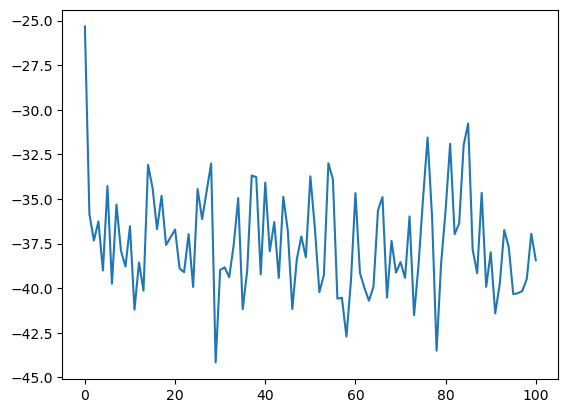

In [6]:
plt.plot(energies);

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import adabmDCA
from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.functional import one_hot

import sys
sys.path.append('..')
import selex_dca, utils

In [8]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [9]:
import importlib
importlib.reload(selex_distribution)

<module 'selex_distribution' from '/home/scrotti/Aptamer2025py/selex_distribution.py'>

In [10]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [11]:
sequences_oh = [one_hot(seq, num_classes=q).to(dtype) for seq in sequences]

In [23]:
batch_size = 32

datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]

In [21]:
def init_chains(
    n_rounds: int,
    n_chains: int,
    L: int,
    q: int,
    device: torch.device,
    dtype: torch.dtype | None = None,
) -> torch.Tensor:

    if dtype is None:
        dtype = torch.float32
    chains = [torch.randint(low=0, high=q, size=(n_chains, L), device=device)
            for _ in range(n_rounds)]
    
    chains_tensor = torch.stack([one_hot(c, num_classes=q).to(dtype) for c in chains])
    
    return chains_tensor   # n_rounds, n_chains, L, q

def update_chains(chains, model, n_sweeps):
    n_rounds = chains.shape[0]
    for t in range(n_rounds):
        compute_energy = lambda x : model.compute_energy_up_to_round(x, t-1)
        sampling.sample_metropolis_uniform_sites(chains[t], compute_energy, n_sweeps)



In [24]:
n_sweeps = 10

model = Nst
n_rounds = len(data_loaders) 
n_chains = batch_size
chains = init_chains(n_rounds, n_chains, L, q, device)
update_chains(chains, model, 10)

In [ ]:
def train(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    chains: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    # l2reg: float = 0.0,
    # history : Dict[str, List[float]] = init_history(),
    # progress_bar: bool = True,
):
    n_rounds = len(data_loaders) 
    assert chains.shape[0] == n_rounds

    def halt_condition(epochs):
        c1 = epochs > max_epochs
        return c1

    epochs = 0
    while not halt_condition(epochs):
        for t in range(n_rounds):
            # update chains
            update_chains(chains, model, n_sweeps)
            # extract batch of data from round t

            # compute averages over Nst and data batch

            # backpropagate loss

            # compute convergence metrics

        # do gradient step on params

        # reset gradient

        